# 7.SVM Classifier

*Made by David Serrano for his Final Bachelor Thesis*

This file gets the stored features to classify the tracks using SVM. All the resampling techniques explained in the report are used.

## 7.1. Environment Preparation 

In [ ]:
# Useful general imports
from google.colab import drive

In [ ]:
 # mount the google drive folder to access to all the files in there
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Add the folder called utils that has all the custom modules in .py files
import sys
sys.path.append('/content/drive/MyDrive/TFG/utils')

In [ ]:
from paths import PROJECT_ROOT, HDF5_FOLDER, JSON_FOLDER, USABLE_SEQUENCES, MAX_SQUARE_LEN

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 7.2. Feature Collecting

In [ ]:
STORAGE = False
modelName = 'ResNet50_epoch5_dataAugDegRange5.pt'

### 7.2.1. From Storage


In this section the features are collected from the disk. In other words, the features extracted from the section 6.

In [ ]:
import numpy as np

if STORAGE:
    from JSONLoader import loadData
    X = []
    y = []
    for seq in USABLE_SEQUENCES:
        features_i = loadData(PROJECT_ROOT + '/data/concatenatedFeatures/' + seq + '.h5.json')
        for feat in features_i:
            X.append(feat[0:-1])
            y.append(feat[-1])

    X = np.array(X)
    y = np.array(y)

### 7.2.2. Directly from a model

In [ ]:
concatenated = False

In [ ]:
from torchvision.models import resnet50
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import time
from tqdm.notebook import tqdm

# Custom Imports
from dataPrep import detectionLoader, hdf5Initializer
from dataStructures import Dataset

if not STORAGE:
    # Load the model
    model = resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 128),
        nn.ReLU(),
        nn.Linear(128,3)
    )

    model.load_state_dict(torch.load(PROJECT_ROOT + '/models/' + modelName,
                                     map_location=torch.device('cpu')))
    
    # Delete the final two layers of the model (ReLU and Linnear(128,3))
    model.fc = nn.Sequential(*[model.fc[0]])
    print('The fully connected layer of the model is:\n', model.fc)

    # Initialize the hdf5Loaders and create a Dataloader for each sequence

    print('Creating a DataLoader for each sequence file...')
    dataloaders = []
    for idx, seq in enumerate(USABLE_SEQUENCES):
        loaders = [None] * len(USABLE_SEQUENCES)
        loaders[idx] = hdf5Initializer([seq])[0]
        detections, labels = detectionLoader([seq], tracks=False)
        n=5

        dataset = Dataset(loaders, labels, detections, n, dataAug=False)
        dataloaders.append(DataLoader(dataset=dataset,
                                      batch_size=1,
                                      num_workers=1))

    # Extract the features 
    print('Extracting the features of all the sequence...')
    since = time.time()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model.eval()    # Set model to evaluation mode

    X = []  # Features matrix
    y = []  # Label list

    for idx, dataloader in enumerate(dataloaders):
        print('\tLoading {} with {} batches...'.format(USABLE_SEQUENCES[idx],
                                                       len(dataloader)))
        
        # Iterate over data
        loop = tqdm(dataloader, unit=' batches', leave=False)

        for inputs, labels in loop:
            
            inputs = inputs[0,:,:,:,:]
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            if concatenated:
                features_i = torch.flatten(outputs)
                features_i = features_i.tolist()
                labels = labels.tolist()
            else:
                features_i = torch.mean(outputs, 0)
                features_i = features_i.tolist()
                labels = labels.tolist()

            X.append(features_i)
            y.append(labels[0])
    
    elapsed = time.time() - since
    print('Elapsed time extracting the features: {:.0f}m {:.0f}s'.format(elapsed // 60,
                                                                         elapsed % 60))


The fully connected layer of the model is:
 Sequential(
  (0): Linear(in_features=2048, out_features=128, bias=True)
)
Creating a DataLoader for each sequence file...
Extracting the features of all the sequence...
	Loading 20171207.039_AEQ11 with 52 batches...


	Loading 20171207.043_AEQ11 with 77 batches...


	Loading 20180918.036_AEQ50 with 67 batches...


	Loading 20180918.038_AEQ50 with 70 batches...


	Loading 20180918.040_AEQ50 with 88 batches...


	Loading 20180919.007_AEQ40 with 63 batches...


	Loading 20180920.034_AEQ11 with 70 batches...


	Loading 20181002.028_AEQ20 with 45 batches...


	Loading 20181004.038_AEQ10 with 78 batches...


	Loading 20181004.038_AEQ20 with 69 batches...


	Loading 20181004.038_AEQ40 with 79 batches...


	Loading 20181004.046_AEQ20 with 66 batches...


	Loading 20181004.046_AEQ40 with 62 batches...


	Loading 20181004.046_AEQ50 with 65 batches...


Elapsed time extracting the features: 27m 35s


## 7.3. Feature Scaling

Function to scale features with different possibilities

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

def normalizeData(X, scaler='Standard', range=(0,1)):
    """
    Function to scale features with different parameters
    :param X: feature matrix
    :param scaler: type of scaler ('Standard', 'MaxAbs', 'MinMax')
    :return X_norm: feature matrix normalized
    """

    X_norm = []

    if scaler=='Standard':
        print('Scaling each feature by removing the mean and scaling to unit variance')
        scaler = StandardScaler()
        scaler.fit(X)
        X_norm = scaler.transform(X)

    if scaler=='MaxAbs':
        print('Scaling each feature by its maximum absoulute value.')
        scaler = MaxAbsScaler()
        scaler.fit(X)
        X_norm = scaler.transform(X)

    if scaler=='MinMax':
        print('Normalizing the input data such that the min and max value are', range)
        scaler = MinMaxScaler(feature_range=range)
        scaler.fit(X)
        X_norm = scaler.transform(X)
        
    return X_norm

## 7.4. SVM

### 7.4.1. SMOTE

Normalizing the input data such that the min and max value are (0, 1)
Train dataset with:		 {0: 612, 1: 28, 2: 25}
OverSampled Train dataset with:	 {0: 612, 1: 612, 2: 612}
SVC(C=0.75, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
{'C': 0.75, 'gamma': 1, 'kernel': 'rbf'} None
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       261
           1       1.00      0.46      0.63        13
           2       0.88      0.58      0.70        12

    accuracy                           0.95       286
   macro avg       0.94      0.68      0.77       286
weighted avg       0.95      0.95      0.95       286



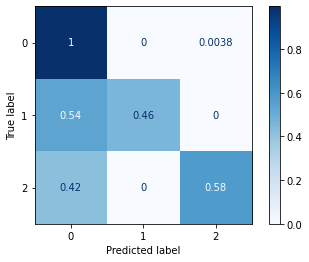

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
from sklearn import svm
import matplotlib.pyplot as plt
import numpy as np

X_norm = normalizeData(X, scaler='MinMax', range=(0,1))

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, train_size=0.7,
                                                    test_size=0.3,
                                                    random_state=101)

oversample = SMOTE(random_state=12)
X_train_OS, y_train_OS = oversample.fit_resample(X_train, y_train)

unique, count = np.unique(y_train, return_counts=True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique.astype(int), count)}
print('Train dataset with:\t\t', y_train_dict_value_count)

unique, count = np.unique(y_train_OS, return_counts=True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique.astype(int), count)}
print('OverSampled Train dataset with:\t', y_train_dict_value_count)

param_grid = [{'kernel': ['rbf'], 'gamma': [1, 0.25, 0.1, 0.075, 0.01],
               'C': [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 1, 2.5, 5, 7,5, 10]},
              {'kernel': ['linear'],
               'C': [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 1, 2.5, 5, 7,5, 10]},
              {'kernel': ['poly'], 'degree': [2, 3, 4, 5, 6, 7],
               'gamma': [1, 0.25, 0.1, 0.075, 0.01],
               'C': [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 1, 2.5, 5, 7,5, 10]}
]
         
grid = GridSearchCV(svm.SVC(), param_grid, cv=5, scoring='f1_macro')

grid.fit(X_train_OS, y_train_OS)

print(grid.best_params_, print(grid.best_estimator_))

grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

disp = plot_confusion_matrix(grid, X_test, y_test,
                                 display_labels=[0, 1, 2],
                                 cmap=plt.cm.Blues,
                                 normalize='true')

### 7.4.2. BorderlineSMOTE

Normalizing the input data such that the min and max value are (0, 1)
Train dataset with:		 {0: 612, 1: 28, 2: 25}
OverSampled Train dataset with:	 {0: 612, 1: 612, 2: 612}
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.25, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
{'C': 10, 'gamma': 0.25, 'kernel': 'rbf'} None
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       261
           1       1.00      0.69      0.82        13
           2       0.80      0.67      0.73        12

    accuracy                           0.97       286
   macro avg       0.92      0.78      0.84       286
weighted avg       0.96      0.97      0.96       286



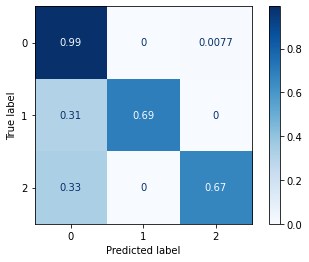

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
from sklearn import svm
import matplotlib.pyplot as plt

X_norm = normalizeData(X, scaler='MinMax', range=(0,1))

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, train_size=0.7,
                                                    test_size=0.3,
                                                    random_state=101)

oversample = BorderlineSMOTE(random_state=12)
X_train_OS, y_train_OS = oversample.fit_resample(X_train, y_train)

unique, count = np.unique(y_train, return_counts=True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique.astype(int), count)}
print('Train dataset with:\t\t', y_train_dict_value_count)

unique, count = np.unique(y_train_OS, return_counts=True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique.astype(int), count)}
print('OverSampled Train dataset with:\t', y_train_dict_value_count)

param_grid = [{'kernel': ['rbf'], 'gamma': [1, 0.25, 0.1, 0.075, 0.01],
               'C': [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 1, 2.5, 5, 7,5, 10]},
              {'kernel': ['linear'],
               'C': [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 1, 2.5, 5, 7,5, 10]},
              {'kernel': ['poly'], 'degree': [2, 3, 4, 5, 6, 7],
               'gamma': [1, 0.25, 0.1, 0.075, 0.01],
               'C': [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 1, 2.5, 5, 7,5, 10]}
]
         
grid = GridSearchCV(svm.SVC(), param_grid, cv=5, scoring='f1_macro')

grid.fit(X_train_OS, y_train_OS)

print(grid.best_params_, print(grid.best_estimator_))

grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

disp = plot_confusion_matrix(grid, X_test, y_test,
                                 display_labels=[0, 1, 2],
                                 cmap=plt.cm.Blues,
                                 normalize='true')

### 7.4.3. ADASYN

Normalizing the input data such that the min and max value are (0, 1)
Train dataset with:		 {0: 612, 1: 28, 2: 25}
OverSampled Train dataset with:	 {0: 612, 1: 613, 2: 607}
SVC(C=7, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.25, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
{'C': 7, 'gamma': 0.25, 'kernel': 'rbf'} None
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       261
           1       0.83      0.77      0.80        13
           2       0.89      0.67      0.76        12

    accuracy                           0.97       286
   macro avg       0.90      0.81      0.85       286
weighted avg       0.96      0.97      0.96       286



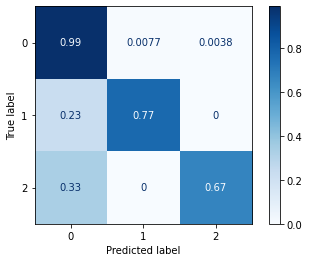

In [ ]:
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
from sklearn import svm
import matplotlib.pyplot as plt

X_norm = normalizeData(X, scaler='MinMax', range=(0,1))

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, train_size=0.7,
                                                    test_size=0.3,
                                                    random_state=101)

oversample = ADASYN(random_state=12)
X_train_OS, y_train_OS = oversample.fit_resample(X_train, y_train)

unique, count = np.unique(y_train, return_counts=True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique.astype(int), count)}
print('Train dataset with:\t\t', y_train_dict_value_count)

unique, count = np.unique(y_train_OS, return_counts=True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique.astype(int), count)}
print('OverSampled Train dataset with:\t', y_train_dict_value_count)

param_grid = [{'kernel': ['rbf'], 'gamma': [1, 0.25, 0.1, 0.075, 0.01],
               'C': [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 1, 2.5, 5, 7,5, 10]},
              {'kernel': ['linear'],
               'C': [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 1, 2.5, 5, 7,5, 10]},
              {'kernel': ['poly'], 'degree': [2, 3, 4, 5, 6, 7],
               'gamma': [1, 0.25, 0.1, 0.075, 0.01],
               'C': [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 1, 2.5, 5, 7,5, 10]}
]
         
grid = GridSearchCV(svm.SVC(), param_grid, cv=5, scoring='f1_macro')

grid.fit(X_train_OS, y_train_OS)

print(grid.best_params_, print(grid.best_estimator_))

grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

disp = plot_confusion_matrix(grid, X_test, y_test,
                                 display_labels=[0, 1, 2],
                                 cmap=plt.cm.Blues,
                                 normalize='true')

## 7.4.4. SMOTEENN


Normalizing the input data such that the min and max value are (0, 1)
Train dataset with:		 {0: 612, 1: 28, 2: 25}
OverSampled Train dataset with:	 {0: 487, 1: 612, 2: 612}
SVC(C=0.4, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
{'C': 0.4, 'gamma': 1, 'kernel': 'rbf'} None
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       261
           1       1.00      0.54      0.70        13
           2       0.77      0.83      0.80        12

    accuracy                           0.96       286
   macro avg       0.91      0.79      0.83       286
weighted avg       0.96      0.96      0.96       286



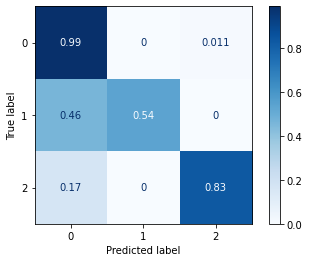

In [ ]:
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
from sklearn import svm
import matplotlib.pyplot as plt

X_norm = normalizeData(X, scaler='MinMax', range=(0,1))

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, train_size=0.7,
                                                    test_size=0.3,
                                                    random_state=101)

oversample = SMOTEENN(random_state=12)
X_train_OS, y_train_OS = oversample.fit_resample(X_train, y_train)

unique, count = np.unique(y_train, return_counts=True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique.astype(int), count)}
print('Train dataset with:\t\t', y_train_dict_value_count)

unique, count = np.unique(y_train_OS, return_counts=True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique.astype(int), count)}
print('OverSampled Train dataset with:\t', y_train_dict_value_count)

param_grid = [{'kernel': ['rbf'], 'gamma': [1, 0.25, 0.1, 0.075, 0.01],
               'C': [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 1, 2.5, 5, 7,5, 10]},
              {'kernel': ['linear'],
               'C': [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 1, 2.5, 5, 7,5, 10]},
              {'kernel': ['poly'], 'degree': [2, 3, 4, 5, 6, 7],
               'gamma': [1, 0.25, 0.1, 0.075, 0.01],
               'C': [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 1, 2.5, 5, 7,5, 10]}
]
         
grid = GridSearchCV(svm.SVC(), param_grid, cv=5, scoring='f1_macro')

grid.fit(X_train_OS, y_train_OS)

print(grid.best_params_, print(grid.best_estimator_))

grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

disp = plot_confusion_matrix(grid, X_test, y_test,
                                 display_labels=[0, 1, 2],
                                 cmap=plt.cm.Blues,
                                 normalize='true')

## 7.4.5. SMOTETomek


Normalizing the input data such that the min and max value are (0, 1)
Train dataset with:		 {0: 612, 1: 28, 2: 25}
OverSampled Train dataset with:	 {0: 612, 1: 612, 2: 612}
SVC(C=0.75, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
{'C': 0.75, 'gamma': 1, 'kernel': 'rbf'} None
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       261
           1       1.00      0.46      0.63        13
           2       0.88      0.58      0.70        12

    accuracy                           0.95       286
   macro avg       0.94      0.68      0.77       286
weighted avg       0.95      0.95      0.95       286



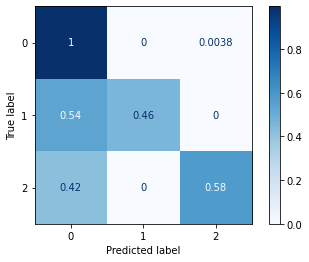

In [ ]:
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
from sklearn import svm
import matplotlib.pyplot as plt

X_norm = normalizeData(X, scaler='MinMax', range=(0,1))

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, train_size=0.7,
                                                    test_size=0.3,
                                                    random_state=101)

oversample = SMOTETomek(random_state=12)
X_train_OS, y_train_OS = oversample.fit_resample(X_train, y_train)

unique, count = np.unique(y_train, return_counts=True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique.astype(int), count)}
print('Train dataset with:\t\t', y_train_dict_value_count)

unique, count = np.unique(y_train_OS, return_counts=True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique.astype(int), count)}
print('OverSampled Train dataset with:\t', y_train_dict_value_count)

param_grid = [{'kernel': ['rbf'], 'gamma': [1, 0.25, 0.1, 0.075, 0.01],
               'C': [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 1, 2.5, 5, 7,5, 10]},
              {'kernel': ['linear'],
               'C': [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 1, 2.5, 5, 7,5, 10]},
              {'kernel': ['poly'], 'degree': [2, 3, 4, 5, 6, 7],
               'gamma': [1, 0.25, 0.1, 0.075, 0.01],
               'C': [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 1, 2.5, 5, 7,5, 10]}
]
         
grid = GridSearchCV(svm.SVC(), param_grid, cv=5, scoring='f1_macro')

grid.fit(X_train_OS, y_train_OS)

print(grid.best_params_, print(grid.best_estimator_))

grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

disp = plot_confusion_matrix(grid, X_test, y_test,
                                 display_labels=[0, 1, 2],
                                 cmap=plt.cm.Blues,
                                 normalize='true')